# Notebook 2 - Inference

In this notebook we use `harissa` to perform network inference from a small dataset with 4 genes.

In [1]:
import numpy as np
from pathlib import Path

from harissa import NetworkModel, NetworkParameter
from harissa.core import Dataset

fname = 'data.npz'
fname_3_0_11 = 'data_3.0.11.txt'
fname_4_0_0 = 'data_4.0.0.npz'
data_path = Path(fname_3_0_11)

## Network

Let us start by defining a test network which will represent the ground truth. Note that the underlying dynamical model has quantitative parameters.

In [2]:
# Initialize model parameters with 4 genes
n_genes = 4
param = NetworkParameter(n_genes)

# Set degradation rates
param.degradation_rna[:] = 1.0
param.degradation_protein[:] = 0.2

param.burst_frequency_min[:] = 0.0 * param.degradation_rna
param.burst_frequency_max[:] = 2.0 * param.degradation_rna

# Set creation rates
param.creation_rna[:] = param.degradation_rna * param.rna_scale() 
param.creation_protein[:] = param.degradation_protein * param.protein_scale()

print(param.creation_protein)

# Set basal activities
param.basal[1:] = -5.0

# Set interactions
param.interaction[0,1] = 10.0
param.interaction[1,2] = 10.0
param.interaction[1,3] = 10.0
param.interaction[3,4] = 10.0
param.interaction[4,1] = -10.0
param.interaction[2,2] = 10.0
param.interaction[3,3] = 10.0

# Initialize model
model = NetworkModel(param)

[-- 0.002 0.002 0.002 0.002]


The `harissa.utils` module provides `build_pos` and `plot_network` to visualize networks.

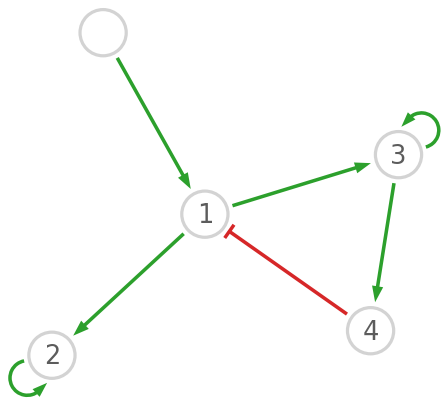

In [3]:
import matplotlib.pyplot as plt
from harissa.plot import build_pos, plot_network

# Number of genes including stimulus
G = param.n_genes_stim

# Node labels and positions
names = [''] + [f'{i+1}' for i in range(G)]
pos = build_pos(param.interaction) * 0.8

# Draw the network
fig = plt.figure(figsize=(5,5))
plot_network(param.interaction, pos, axes=fig.gca(), names=names, scale=3)

## Dataset

We start by generating a sample time-course scRNA-seq dataset: here the main function is `model.simulate()`. The dynamical model is first run during a certain time without stimulus (`burnin` parameter) before activating it at $t=0$. Each single cell is then collected at a particular time point $t > 0$ during the simulated experiment: in this example there are 10 experimental time points and `C`/10 cells per time point.

In [4]:
# Simulate a time-course scRNA-seq dataset
C = 1000
if not data_path.is_file():
    times = np.floor(np.linspace(0.0, 20.0, 10))
    n_cells_per_time_point = C // times.size # 100
    data = model.simulate_dataset(
        time_points = times, 
        n_cells=n_cells_per_time_point, 
        burn_in_duration=5.0
    )
    # Save data in basic format
    data.save(data_path)
    print(f'Dataset file {data_path} has been generated.')
else:
    data = (
        Dataset.load(data_path) if data_path.suffix == '.npz' else 
        Dataset.load_txt(data_path)
    )
    print(f'Dataset file {data_path} loaded.')

Dataset file data_3.0.11.txt loaded.


Note that each scRNA-seq count is obtained by sampling from a Poisson distribution whose rate (mean) parameter is given by the corresponding continuous-valued mRNA level from the stochastic dynamical model. A typical way to implement technical factors (efficiency of reverse transcription, sequencing depth, etc.) would be to first multiply, before applying the Poisson distribution, the continuous values by scaling factors.

In [5]:
print(data)

Dataset(time_points=array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2

Each row corresponds to a single cell; the first column contains time points, while other columns contain gene expression counts.

## Population-average trajectories

NameError: name 'C' is not defined

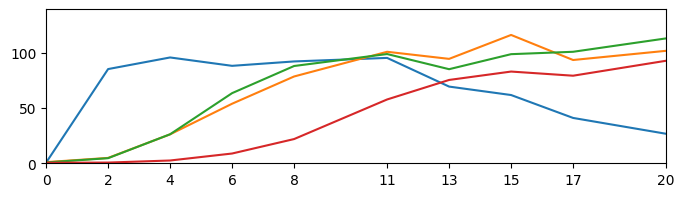

In [6]:
time = np.unique(data.time_points)
T = np.size(time)
# Average for each time point
traj = np.zeros((T,G-1))
for k, t in enumerate(time):
    traj[k] = np.mean(data.count_matrix[data.time_points==t, 1:], axis=0)
# Draw trajectory and export figure
fig = plt.figure(figsize=(8,2))
labels = [rf'$\langle M_{g} \rangle$' for g in range(1,G)]
plt.plot(time, traj, label=labels)
ax = plt.gca()
ax.set_xlim(time[0], time[-1])
ax.set_ylim(0, 1.2*np.max(traj))
ax.set_xticks(time)
ax.set_title(f'Bulk-average trajectory ({int(C/T)} cells per time point)')
ax.legend(loc='upper left', ncol=G, borderaxespad=0, frameon=False)

## Network Inference

Here the main function is `model.fit()`. The first call may take a while due to the Numba compilation (activated by default).

In [ ]:
param_known = NetworkParameter(n_genes)
param_known.degradation_rna[:] = param.degradation_rna
param_known.degradation_protein[:] = param.degradation_protein

model = NetworkModel(param_known)
# Calibrate the model
model.fit(data)
# Show inferred links
print(model.interaction)


Note that the first column of `model.inter` will always be 0 since the stimulus (gene 0) has no feedback by hypothesis. In order to better visualize the results, we can apply a cutoff to edge weights:

In [ ]:
cutoff = 1
inter_c = (np.abs(model.interaction) > cutoff) * model.interaction
print(inter_c) 

Hopefully this looks nice!

In [ ]:
# Draw the network
fig = plt.figure(figsize=(5,5))
plot_network(inter_c, pos, axes=fig.gca(), names=names, scale=3)

Note that self-interactions are notoriously difficult to infer; they are usually not considered in performance evaluations.

### Option: disable Numba

To perform inference without Numba acceleration, set the `use_numba` option to `False` (useful when Numba is not available or generates errors).

In [ ]:
from harissa.inference import Hartree
model = NetworkModel(param_known, inference=Hartree(use_numba=False))
# Calibrate the model
model.fit(data)
# Show inferred links
print(model.interaction)

You can now delete `data.txt` and try to generate new data with different values for `C` (number of cells) to see its impact on performance.